In [ ]:
# !pip install torch==2.2
# !pip install torchvision
# !pip install seaborn
# !pip install numpy
# !pip install matplotlib
# !pip install torchsummary
# !pip install torchview
# !pip install graphviz
# !pip install torchviz
# !pip install pandas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
BATCH_SIZE = 64
num_epoch = 40
learning_rate = 1e-4
class_size = 10

In [ ]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.7),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
torch.manual_seed(2024)

train = torchvision.datasets.CIFAR100("./data-cifar100/", train=True, download=True, transform=transform_train)
test = torchvision.datasets.CIFAR100("./data-cifar100/", train=False, download=True, transform=transform_test)

# val_size = 10000
train_size = len(train)

# train, val = random_split(train, [train_size, val_size])

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 169001437/169001437 [00:10<00:00, 16011803.81it/s]


Extracting ./data-cifar100/cifar-100-python.tar.gz to ./data-cifar100/
Files already downloaded and verified


shape:  torch.Size([64, 3, 224, 224])


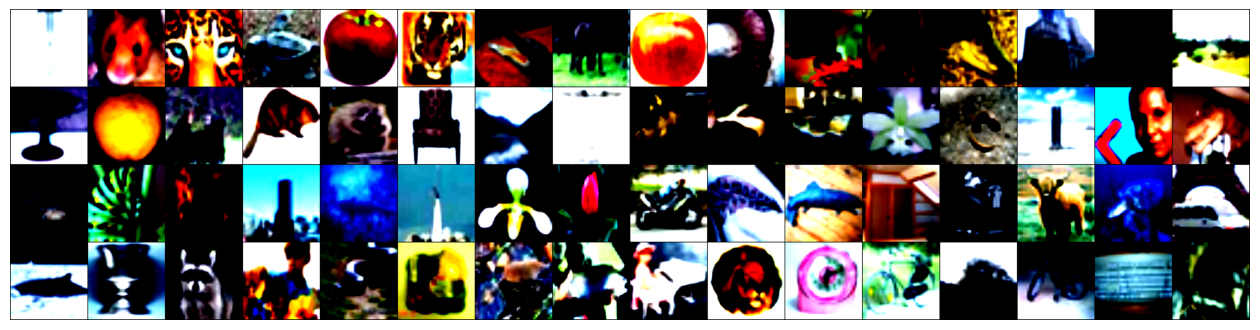

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    print('shape: ', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    # plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
input_last_year = model.fc.in_features
model.fc = nn.Linear(input_last_year, 100)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
epoch_loss_history = []
epoch_acc_history = []

In [20]:

for epoch in range(num_epoch):
    epoch_avg_loss = 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1) == labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_avg_loss += loss_value.item()

        accuracy = (n_corrects / labels.size(0)) * 100

        if (i+1) % 250 == 0:
            print(f'epoch {epoch + 1}/{num_epoch}, step: {i + 1}/{train_size/BATCH_SIZE}: loss = {loss_value:.5f}, acc = {accuracy:.2f}')

    epoch_loss_history.append(epoch_avg_loss / len(train_loader))

    with torch.no_grad():
        correct = 0
        samples = 0

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = outputs.max(1)
            correct += (predictions == labels).sum()
            samples += predictions.size(0)

        accuracy = float(correct) / float(samples) * 100
        epoch_acc_history.append(accuracy)

        print(f"epoch {epoch + 1}/{num_epoch}, val accuracy = {accuracy:.2f}%. Correct {correct} out of {samples} samples")

epoch 1/40, step: 250/781.25: loss = 2.64398, acc = 39.06
epoch 1/40, step: 500/781.25: loss = 2.70334, acc = 25.00
epoch 1/40, step: 750/781.25: loss = 2.76809, acc = 34.38
epoch 1/40, val accuracy = 28.82%. Correct 2882 out of 10000 samples
epoch 2/40, step: 250/781.25: loss = 2.87077, acc = 25.00
epoch 2/40, step: 500/781.25: loss = 2.60912, acc = 39.06
epoch 2/40, step: 750/781.25: loss = 2.67491, acc = 39.06
epoch 2/40, val accuracy = 29.42%. Correct 2942 out of 10000 samples
epoch 3/40, step: 250/781.25: loss = 2.67854, acc = 29.69
epoch 3/40, step: 500/781.25: loss = 2.77502, acc = 35.94
epoch 3/40, step: 750/781.25: loss = 2.51124, acc = 40.62
epoch 3/40, val accuracy = 29.10%. Correct 2910 out of 10000 samples
epoch 4/40, step: 250/781.25: loss = 2.71662, acc = 29.69
epoch 4/40, step: 500/781.25: loss = 2.66797, acc = 32.81
epoch 4/40, step: 750/781.25: loss = 2.56605, acc = 39.06
epoch 4/40, val accuracy = 29.93%. Correct 2993 out of 10000 samples
epoch 5/40, step: 250/781.25

In [21]:
print(epoch_loss_history)
with open('/content/drive/MyDrive/res/history/resnet_cifar_refrence_loss_history_no_tl.txt', "w") as f:
    for item in epoch_loss_history:
        f.write(f'{item:.5f}\n')

[4.485472267546007, 4.287156508096953, 4.162262977236677, 4.067515142738362, 3.9863092756027454, 3.9166290577110425, 3.8516310611954125, 3.796729740584293, 3.742114357326342, 3.6942313382082888, 3.650896005313415, 3.6107645144547953, 3.5762352702562765, 3.5395786478696274, 3.503193455583909, 3.473036225189638, 3.443010518313064, 3.415442095388232, 3.3857863190228983, 3.3609505876555774, 3.3313114063819045, 3.3058682579518583, 3.28022560500123, 3.2535019765424606, 3.228090629248363, 3.203041926369338, 3.1773630197700635, 3.152237347629674, 3.125170694897547, 3.095415404995384, 3.0720003453057134, 3.0490611319041925, 3.0175407731624517, 2.994450180122005, 2.96757267167806, 2.9430385468256137, 2.922410214648527, 2.896285034811405, 2.8743851584241824, 2.8490504419712153, 2.8277059668470224, 2.804174774138214, 2.7811433128688647, 2.7578437572245096, 2.7379057645187963, 2.7163302221566514, 2.6925035870593526, 2.6716464745723987, 2.651637096844061, 2.628902795979434, 2.6036254344388956, 2.582

In [22]:
print(epoch_acc_history)
with open('/content/drive/MyDrive/res/history/resnet_cifar_refrence_acc_history_no_tl.txt', "w") as f:
    for item in epoch_acc_history:
        f.write(f'{item:.5f}\n')

[5.609999999999999, 7.3999999999999995, 8.97, 9.85, 10.979999999999999, 11.99, 12.709999999999999, 12.93, 13.68, 14.149999999999999, 14.729999999999999, 15.310000000000002, 15.78, 16.24, 16.79, 17.45, 18.490000000000002, 18.59, 18.69, 19.55, 20.03, 20.9, 21.15, 21.25, 21.790000000000003, 21.97, 23.03, 23.43, 23.549999999999997, 24.310000000000002, 24.73, 24.5, 25.66, 25.83, 26.72, 26.650000000000002, 27.04, 27.500000000000004, 27.76, 28.689999999999998, 28.82, 29.42, 29.099999999999998, 29.93, 30.2, 30.459999999999997, 31.47, 31.66, 32.06, 32.32, 32.37, 33.06, 33.4, 33.87, 34.11, 34.61, 34.69, 34.99, 35.589999999999996, 35.75, 36.32, 36.38, 36.76, 36.66, 37.169999999999995, 37.63, 37.72, 37.91, 38.51, 38.58, 38.75, 38.9, 39.26, 39.290000000000006, 39.34, 39.69, 40.37, 40.17, 40.45, 40.339999999999996]


In [23]:
torch.save(model, '/content/drive/MyDrive/res/history/resnet_cifar_reference_no_tl.pth')